In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Create a synthetic time series dataset
np.random.seed(42)
n_samples = 500

In [3]:
# Time index
time_idx = np.arange(n_samples)

In [4]:
# Create some base features
trend = 0.05 * time_idx
seasonal = 5 * np.sin(time_idx * (2 * np.pi / 50))  # Seasonality with period 50
noise = np.random.normal(0, 1, n_samples)

In [5]:
# Target variable: combination of trend, seasonality, and noise
y = trend + seasonal + noise

In [6]:
# Create feature matrix with a mix of useful and noisy features
X = np.column_stack([
    trend,                                    # Trend feature - useful
    seasonal,                                 # Seasonal feature - useful
    np.sin(time_idx * (2 * np.pi / 25)),      # Another seasonal pattern - somewhat useful
    np.random.normal(0, 1, n_samples),        # Pure noise - not useful
    np.random.normal(0, 1, n_samples),        # Pure noise - not useful
    0.7 * trend + np.random.normal(0, 0.5, n_samples),  # Correlated with trend - somewhat useful
    0.3 * seasonal + np.random.normal(0, 2, n_samples), # Weakly correlated with seasonal - less useful
    0.1 * time_idx + np.random.normal(0, 3, n_samples), # Very weak signal - barely useful
    np.random.normal(0, 1, n_samples),        # Pure noise - not useful
    np.cos(time_idx * (2 * np.pi / 50)),      # Related to seasonality - useful
])

In [7]:
# Feature names
feature_names = [
    'trend', 'seasonality', 'seasonality_2', 'noise_1', 'noise_2', 
    'trend_correlated', 'seasonality_correlated', 'weak_trend', 'noise_3', 'cos_seasonality'
]

In [8]:
# Create DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y
df['time'] = time_idx

print("Dataset shape:", df.shape)
print("\nFeature names:", feature_names)
print("\nFirst few rows of data:")
df.head()

Dataset shape: (500, 12)

Feature names: ['trend', 'seasonality', 'seasonality_2', 'noise_1', 'noise_2', 'trend_correlated', 'seasonality_correlated', 'weak_trend', 'noise_3', 'cos_seasonality']

First few rows of data:


,trend,seasonality,seasonality_2,noise_1,noise_2,trend_correlated,seasonality_correlated,weak_trend,noise_3,cos_seasonality,target,time
0,0.00,0.000000,0.000000,0.926178,1.399355,0.389181,-1.350357,1.711839,-1.907808,1.000000,0.496714,0
1,0.05,0.626666,0.248690,1.909417,0.924634,-0.240593,-0.101037,3.004554,-0.860385,0.992115,0.538402,1
2,0.10,1.243449,0.481754,-1.398568,0.059630,-0.339099,-1.211805,-0.793925,-0.413606,0.968583,1.991138,2
3,0.15,1.840623,0.684547,0.562969,-0.646937,0.103313,-0.063736,-1.536710,1.887688,0.929776,3.513653,3
4,0.20,2.408768,0.844328,-0.650643,0.698223,0.054908,-3.064599,-2.855452,0.556553,0.876307,2.374615,4


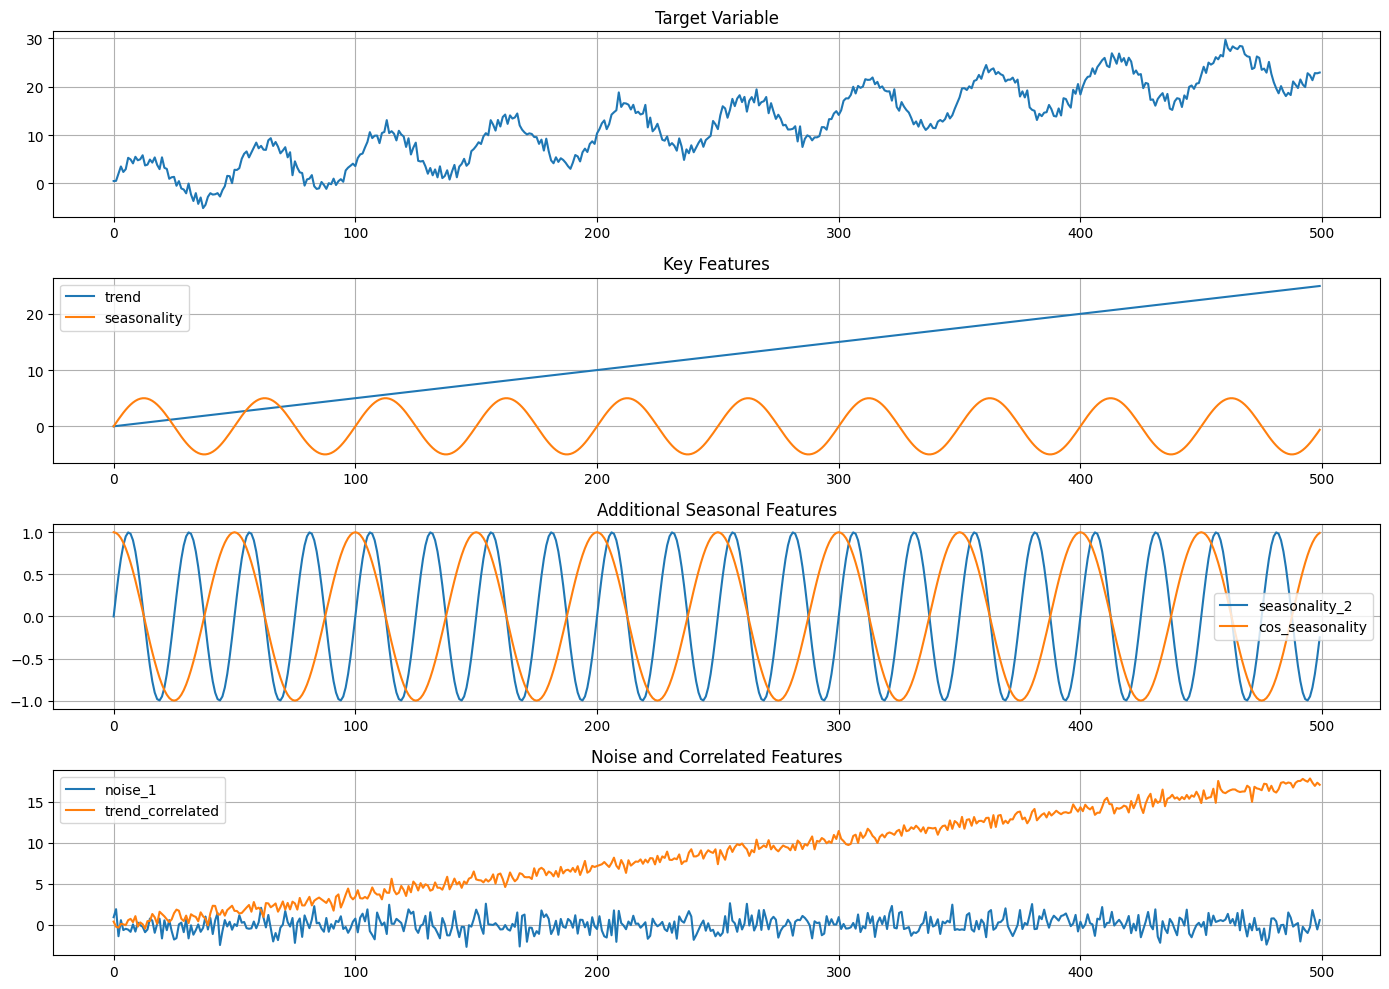

In [9]:
# Plot the time series data
plt.figure(figsize=(14, 10))

# Plot target variable
plt.subplot(411)
plt.plot(df['time'], df['target'])
plt.title('Target Variable')
plt.grid(True)

# Plot some features
plt.subplot(412)
plt.plot(df['time'], df['trend'], label='trend')
plt.plot(df['time'], df['seasonality'], label='seasonality')
plt.legend()
plt.title('Key Features')
plt.grid(True)

plt.subplot(413)
plt.plot(df['time'], df['seasonality_2'], label='seasonality_2')
plt.plot(df['time'], df['cos_seasonality'], label='cos_seasonality')
plt.legend()
plt.title('Additional Seasonal Features')
plt.grid(True)

plt.subplot(414)
plt.plot(df['time'], df['noise_1'], label='noise_1')
plt.plot(df['time'], df['trend_correlated'], label='trend_correlated')
plt.legend()
plt.title('Noise and Correlated Features')
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Function to evaluate model with time series cross-validation
def evaluate_time_series_model(model, X, y, cv):
    mse_scores = []
    r2_scores = []
    predictions = np.zeros_like(y)
    
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Fit model
        model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        
        # Store predictions
        predictions[test_idx] = y_pred
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        mse_scores.append(mse)
        r2_scores.append(r2)
    
    return {
        'mse': np.mean(mse_scores),
        'mse_std': np.std(mse_scores),
        'r2': np.mean(r2_scores),
        'r2_std': np.std(r2_scores),
        'predictions': predictions
    }

In [11]:
# Function to evaluate RFE with time series cross-validation
def evaluate_rfe_time_series(X, y, cv, estimator, n_features_to_select):
    all_selected_features = []
    mse_scores = []
    r2_scores = []
    predictions = np.zeros_like(y)
    
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Apply RFE
        rfe = RFE(estimator=estimator, n_features_to_select=n_features_to_select, step=1)
        rfe.fit(X_train_scaled, y_train)
        
        # Get selected features
        selected_indices = np.where(rfe.support_)[0]
        selected_features = [feature_names[i] for i in selected_indices]
        all_selected_features.append(selected_features)
        
        # Transform data
        X_train_rfe = rfe.transform(X_train_scaled)
        X_test_rfe = rfe.transform(X_test_scaled)
        
        # Fit model with selected features
        model = clone_estimator(estimator)
        model.fit(X_train_rfe, y_train)
        
        # Predict
        y_pred = model.predict(X_test_rfe)
        
        # Store predictions
        predictions[test_idx] = y_pred
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        mse_scores.append(mse)
        r2_scores.append(r2)
    
    # Calculate feature selection stability
    feature_counts = {}
    for features in all_selected_features:
        for feature in features:
            if feature not in feature_counts:
                feature_counts[feature] = 0
            feature_counts[feature] += 1
    
    feature_probs = {feature: count / len(all_selected_features) 
                     for feature, count in feature_counts.items()}
    
    return {
        'mse': np.mean(mse_scores),
        'mse_std': np.std(mse_scores),
        'r2': np.mean(r2_scores),
        'r2_std': np.std(r2_scores),
        'predictions': predictions,
        'selected_features': all_selected_features,
        'feature_probs': feature_probs
    }

In [12]:
# Clone a scikit-learn estimator (helper function)
def clone_estimator(estimator):
    if isinstance(estimator, RandomForestRegressor):
        return RandomForestRegressor(
            n_estimators=estimator.n_estimators,
            random_state=estimator.random_state
        )
    elif isinstance(estimator, LinearRegression):
        return LinearRegression()
    else:
        # Add other estimators as needed
        return estimator

# Evaluate baseline model (all features)
baseline_rf = RandomForestRegressor(n_estimators=100, random_state=42)
baseline_results = evaluate_time_series_model(baseline_rf, X, y, tscv)

print("\nBaseline results (all features):")
print(f"MSE: {baseline_results['mse']:.4f} ± {baseline_results['mse_std']:.4f}")
print(f"R²: {baseline_results['r2']:.4f} ± {baseline_results['r2_std']:.4f}")


Baseline results (all features):
MSE: 10.2566 ± 1.7947
R²: 0.3327 ± 0.1294


Evaluating RFE with 1 features...
Evaluating RFE with 2 features...
Evaluating RFE with 3 features...
Evaluating RFE with 4 features...
Evaluating RFE with 5 features...
Evaluating RFE with 6 features...
Evaluating RFE with 7 features...
Evaluating RFE with 8 features...
Evaluating RFE with 9 features...
Evaluating RFE with 10 features...


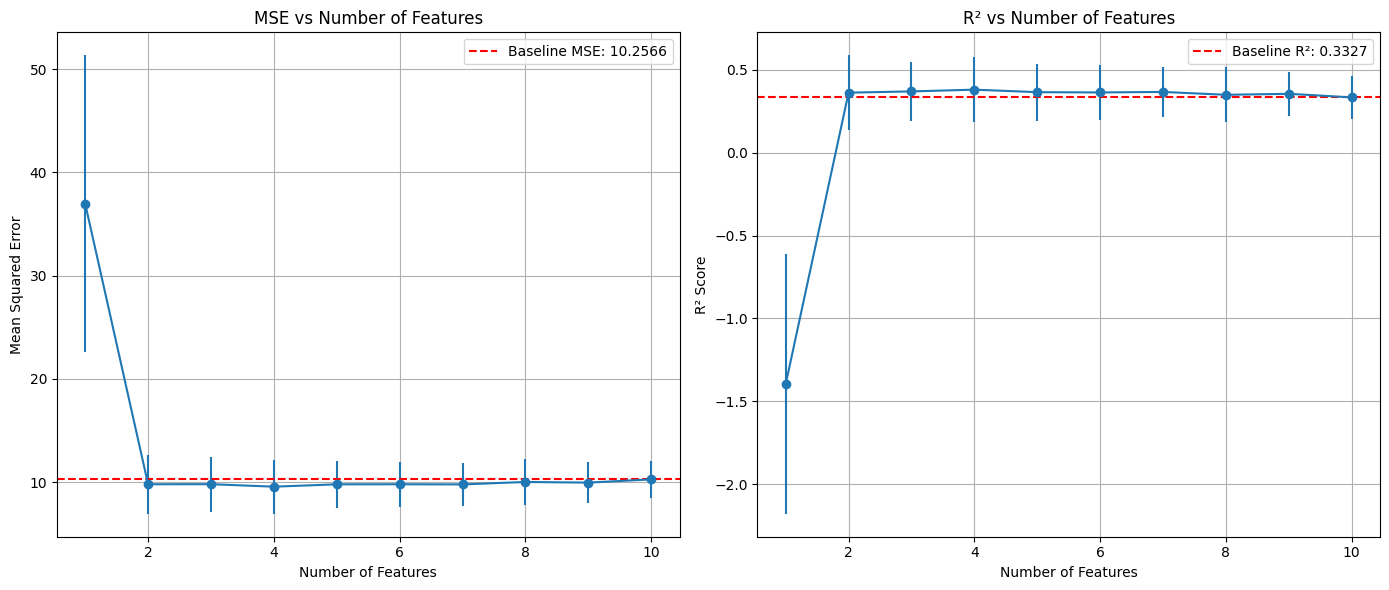

In [13]:
# Try RFE with different number of features
n_features_range = range(1, len(feature_names) + 1)
rf_results = []

for n_features in n_features_range:
    print(f"Evaluating RFE with {n_features} features...")
    rf_estimator = RandomForestRegressor(n_estimators=100, random_state=42)
    results = evaluate_rfe_time_series(X, y, tscv, rf_estimator, n_features)
    
    rf_results.append({
        'n_features': n_features,
        'mse': results['mse'],
        'mse_std': results['mse_std'],
        'r2': results['r2'],
        'r2_std': results['r2_std'],
        'feature_probs': results['feature_probs'],
        'predictions': results['predictions']
    })

# Plot results
plt.figure(figsize=(14, 6))

# Plot MSE vs number of features
plt.subplot(121)
plt.errorbar(
    [r['n_features'] for r in rf_results],
    [r['mse'] for r in rf_results],
    yerr=[r['mse_std'] for r in rf_results],
    fmt='o-'
)
plt.axhline(y=baseline_results['mse'], color='r', linestyle='--', 
            label=f'Baseline MSE: {baseline_results["mse"]:.4f}')
plt.xlabel('Number of Features')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Number of Features')
plt.grid(True)
plt.legend()

# Plot R² vs number of features
plt.subplot(122)
plt.errorbar(
    [r['n_features'] for r in rf_results],
    [r['r2'] for r in rf_results],
    yerr=[r['r2_std'] for r in rf_results],
    fmt='o-'
)
plt.axhline(y=baseline_results['r2'], color='r', linestyle='--', 
            label=f'Baseline R²: {baseline_results["r2"]:.4f}')
plt.xlabel('Number of Features')
plt.ylabel('R² Score')
plt.title('R² vs Number of Features')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Determine optimal number of features
optimal_idx = np.argmax([r['r2'] for r in rf_results])
optimal_n_features = rf_results[optimal_idx]['n_features']

print(f"\nOptimal number of features: {optimal_n_features}")


Optimal number of features: 4


In [15]:
# Get feature selection probabilities for optimal number of features
optimal_results = rf_results[optimal_idx]
optimal_feature_probs = optimal_results['feature_probs']

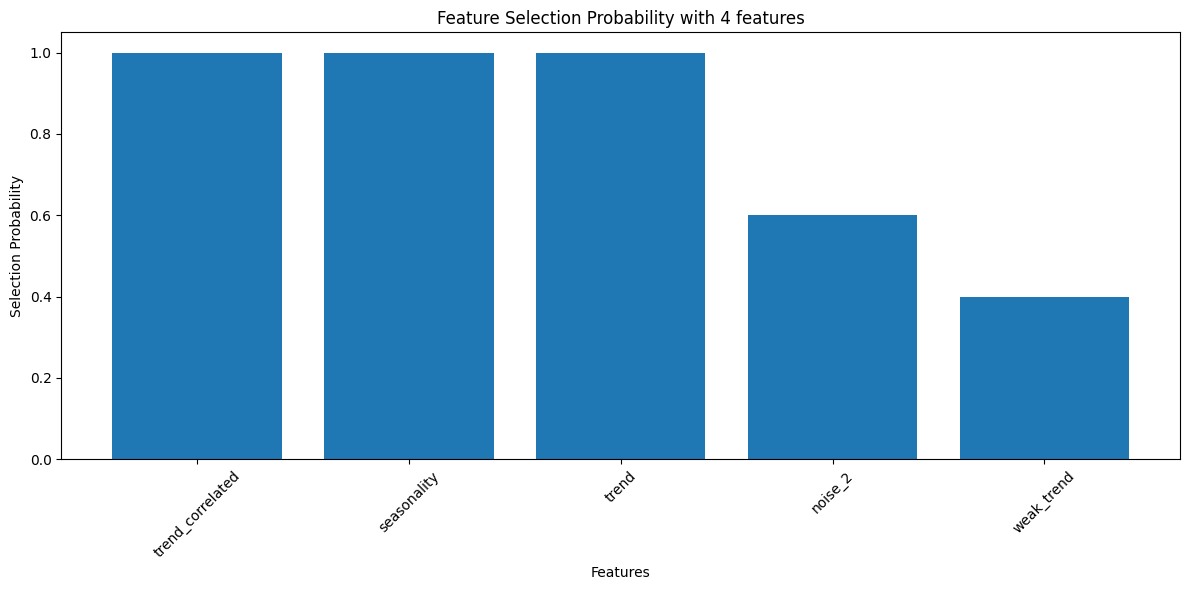

In [17]:
# Visualize feature selection probabilities
plt.figure(figsize=(12, 6))
features = list(optimal_feature_probs.keys())
probs = list(optimal_feature_probs.values())

# Sort by probability
sorted_indices = np.argsort(probs)[::-1]
sorted_features = [features[i] for i in sorted_indices]
sorted_probs = [probs[i] for i in sorted_indices]

plt.bar(sorted_features, sorted_probs)
plt.xlabel('Features')
plt.ylabel('Selection Probability')
plt.title(f'Feature Selection Probability with {optimal_n_features} features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Apply RFE with optimal number of features on the whole dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rf_estimator = RandomForestRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=rf_estimator, n_features_to_select=optimal_n_features, step=1)
rfe.fit(X_scaled, y)

selected_indices = np.where(rfe.support_)[0]
final_selected_features = [feature_names[i] for i in selected_indices]

print("\nFinal selected features:")
for i, feature in enumerate(final_selected_features):
    print(f"{i+1}. {feature}")


Final selected features:
1. trend
2. seasonality
3. trend_correlated
4. weak_trend


In [19]:
# Transform data with selected features
X_rfe = rfe.transform(X_scaled)

# Train final model
final_model = RandomForestRegressor(n_estimators=100, random_state=42)
final_model.fit(X_rfe, y)

# Make predictions
y_pred = final_model.predict(X_rfe)

# Calculate metrics
final_mse = mean_squared_error(y, y_pred)
final_r2 = r2_score(y, y_pred)

print("\nFinal model performance:")
print(f"MSE: {final_mse:.4f}")
print(f"R²: {final_r2:.4f}")


Final model performance:
MSE: 0.1891
R²: 0.9970


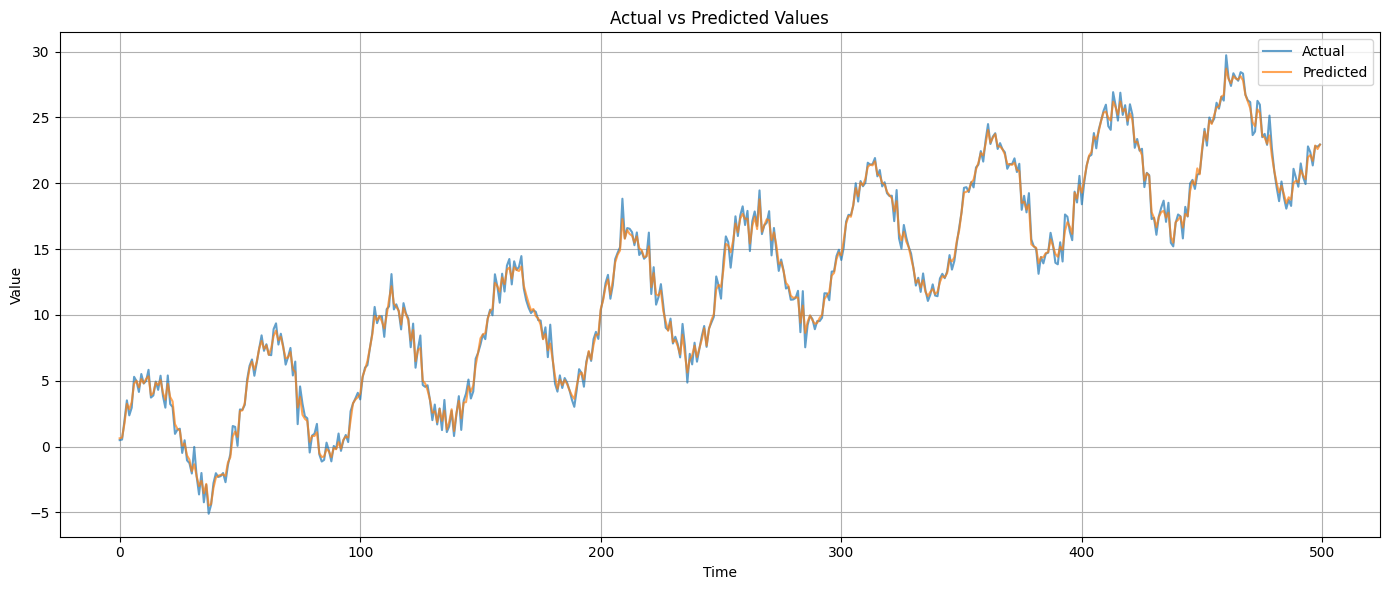

In [20]:
# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(time_idx, y, label='Actual', alpha=0.7)
plt.plot(time_idx, y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

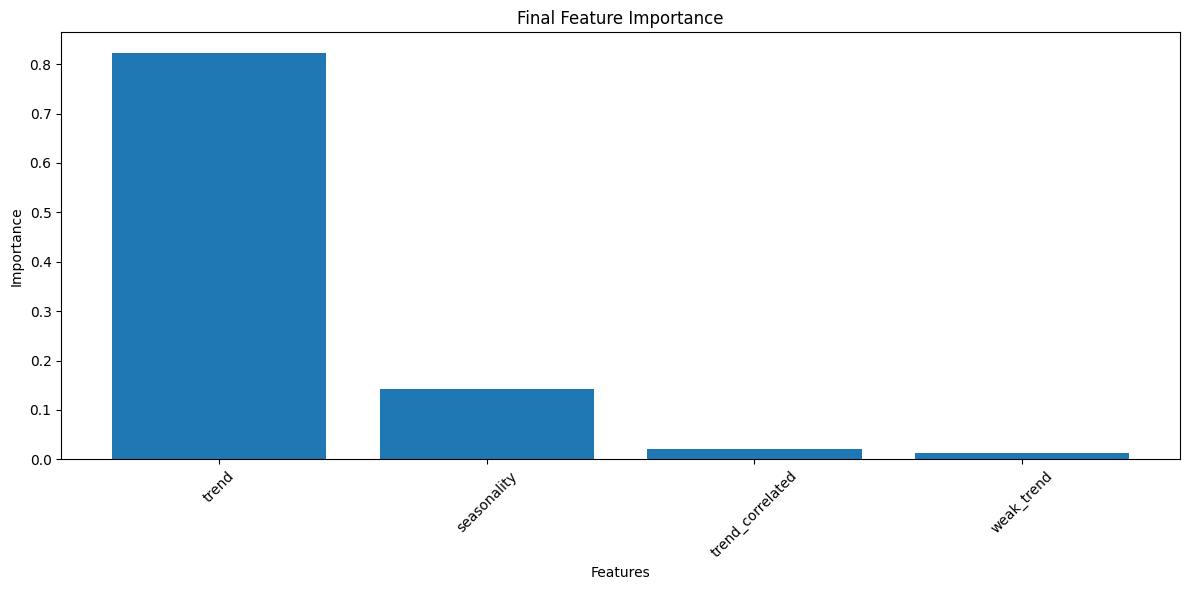

In [21]:
# Plot feature importance of the final model
plt.figure(figsize=(12, 6))
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [final_selected_features[i] for i in indices], rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Final Feature Importance')
plt.tight_layout()
plt.show()

In [22]:
# Compare with different window sizes/lagged features for time series
print("\nTesting with lagged features...")

# Create lagged features
max_lag = 5
lag_features = []
for lag in range(1, max_lag + 1):
    for feature in feature_names:
        lagged = np.zeros_like(y)
        lagged[lag:] = X[:-lag, feature_names.index(feature)]
        lag_features.append(lagged)

# Add lagged features to the dataset
X_with_lags = np.column_stack([X] + lag_features)

# Generate feature names for lagged features
lag_feature_names = []
for lag in range(1, max_lag + 1):
    for feature in feature_names:
        lag_feature_names.append(f"{feature}_lag{lag}")

all_feature_names = feature_names + lag_feature_names

# Remove rows with NaN values (first max_lag rows)
X_with_lags = X_with_lags[max_lag:]
y_lagged = y[max_lag:]
time_idx_lagged = time_idx[max_lag:]

# Apply RFE on dataset with lags
# We'll select more features now since we have more candidates
n_features_to_select_with_lags = optimal_n_features * 2  # Adjust as needed

scaler_lags = StandardScaler()
X_with_lags_scaled = scaler_lags.fit_transform(X_with_lags)

rf_estimator_lags = RandomForestRegressor(n_estimators=100, random_state=42)
rfe_lags = RFE(estimator=rf_estimator_lags, n_features_to_select=n_features_to_select_with_lags, step=1)
rfe_lags.fit(X_with_lags_scaled, y_lagged)

selected_indices_lags = np.where(rfe_lags.support_)[0]
selected_features_lags = [all_feature_names[i] for i in selected_indices_lags]

print("\nSelected features with lags:")
for i, feature in enumerate(selected_features_lags):
    print(f"{i+1}. {feature}")


Testing with lagged features...

Selected features with lags:
1. trend
2. seasonality
3. trend_lag1
4. seasonality_lag1
5. trend_lag2
6. trend_lag3
7. trend_lag4
8. trend_lag5


In [23]:
# Transform data
X_rfe_lags = rfe_lags.transform(X_with_lags_scaled)

# Train final model with lags
final_model_lags = RandomForestRegressor(n_estimators=100, random_state=42)
final_model_lags.fit(X_rfe_lags, y_lagged)

# Make predictions
y_pred_lags = final_model_lags.predict(X_rfe_lags)

# Calculate metrics
final_mse_lags = mean_squared_error(y_lagged, y_pred_lags)
final_r2_lags = r2_score(y_lagged, y_pred_lags)

print("\nFinal model performance with lagged features:")
print(f"MSE: {final_mse_lags:.4f}")
print(f"R²: {final_r2_lags:.4f}")


Final model performance with lagged features:
MSE: 0.1817
R²: 0.9971


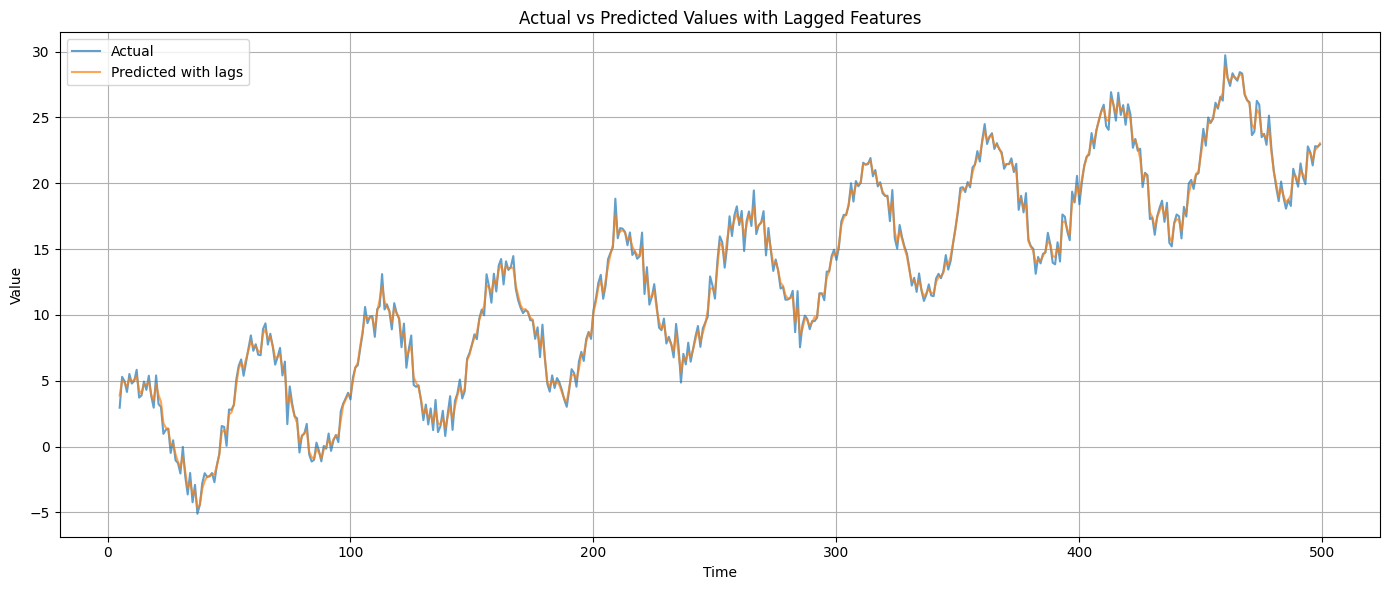

In [24]:
# Plot actual vs predicted with lags
plt.figure(figsize=(14, 6))
plt.plot(time_idx_lagged, y_lagged, label='Actual', alpha=0.7)
plt.plot(time_idx_lagged, y_pred_lags, label='Predicted with lags', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values with Lagged Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
# Compare all methods
print("\nComparison of all methods:")
print(f"Baseline (all features) - MSE: {baseline_results['mse']:.4f}, R²: {baseline_results['r2']:.4f}")
print(f"RFE ({optimal_n_features} features) - MSE: {final_mse:.4f}, R²: {final_r2:.4f}")
print(f"RFE with lags ({n_features_to_select_with_lags} features) - MSE: {final_mse_lags:.4f}, R²: {final_r2_lags:.4f}")


Comparison of all methods:
Baseline (all features) - MSE: 10.2566, R²: 0.3327
RFE (4 features) - MSE: 0.1891, R²: 0.9970
RFE with lags (8 features) - MSE: 0.1817, R²: 0.9971


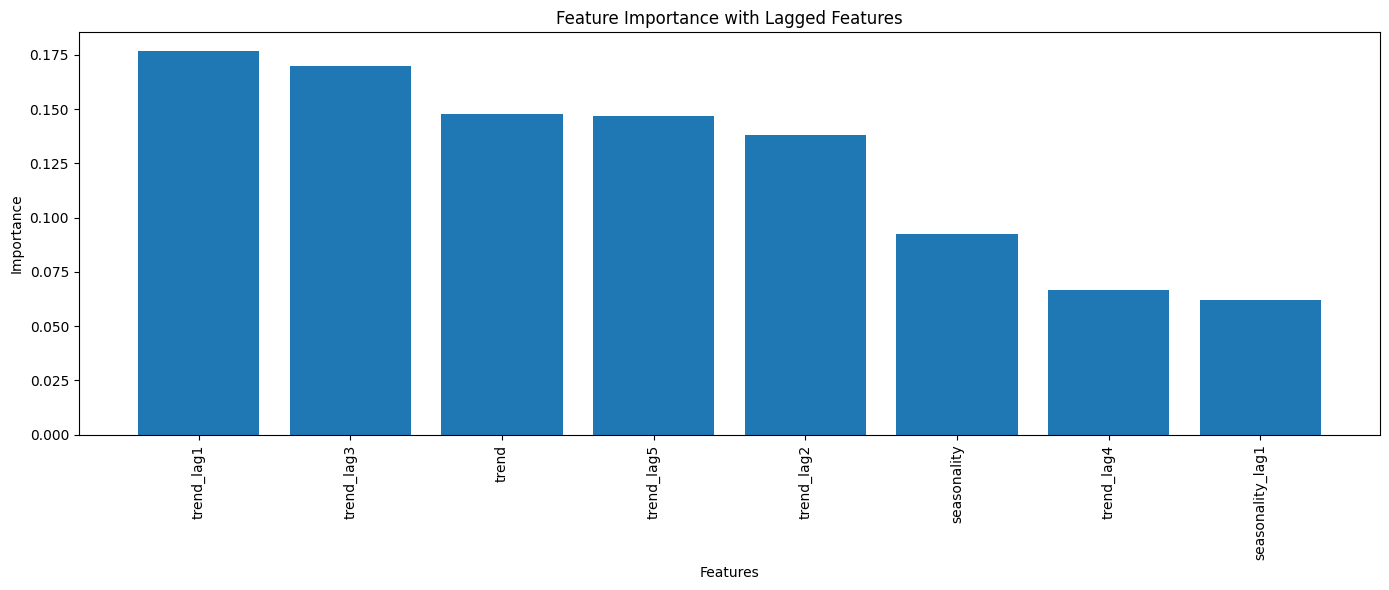

In [26]:
# Plot feature importance of the final model with lags
plt.figure(figsize=(14, 6))
importances_lags = final_model_lags.feature_importances_
indices_lags = np.argsort(importances_lags)[::-1]

plt.bar(range(len(importances_lags)), importances_lags[indices_lags])
plt.xticks(range(len(importances_lags)), [selected_features_lags[i] for i in indices_lags], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance with Lagged Features')
plt.tight_layout()
plt.show()